# Non-explicity of parameters in Neural Networks

This notebook demonstrates that the parameters of a neural network are not always explicit. We will show that the parameters of a neural network can be implicit in the architecture and the data.

In [7]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt


# === 1. Define the MLP ===
class MLP(eqx.Module):
    layers: list
    activation: callable = eqx.static_field()

    def __init__(self, in_size, width, out_size, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        self.layers += [eqx.nn.Linear(width, width, key=k) for k in keys[1:-1]]
        self.layers += [eqx.nn.Linear(width, out_size, key=keys[-1])]
        self.activation = jax.nn.tanh

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)


/var/folders/_2/63g8y8g568q958hmd9yxr2mc0000gp/T/ipykernel_29181/1542413251.py:11: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  activation: callable = eqx.static_field()


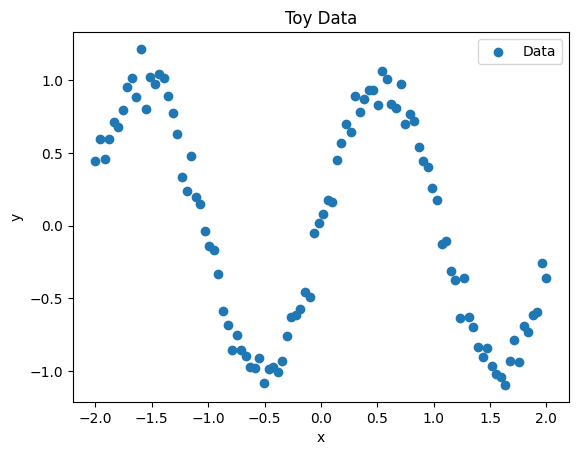

In [8]:
# === 2. Create toy data ===
key = jax.random.PRNGKey(0)
x = jnp.linspace(-2, 2, 100).reshape(-1, 1)
noise = 0.1 * jax.random.normal(key, shape=x.shape)
y = jnp.sin(3 * x) + noise


plt.scatter(x, y, label="Data")
plt.title("Toy Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [9]:
# === 3. Define loss and update ===
@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)


@eqx.filter_jit
def make_step(model, x, y, opt_state, optimizer):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


In [10]:
# === 4. Train function ===
def train_model(seed):
    key = jax.random.PRNGKey(seed)
    model = MLP(1, 32, 1, 2, key)
    optimizer = optax.adam(1e-2)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    for _ in range(1000):
        model, opt_state, _ = make_step(model, x, y, opt_state, optimizer)

    return model


In [11]:
# === 5. Train two networks ===
model1 = train_model(seed=0)
model2 = train_model(seed=42)


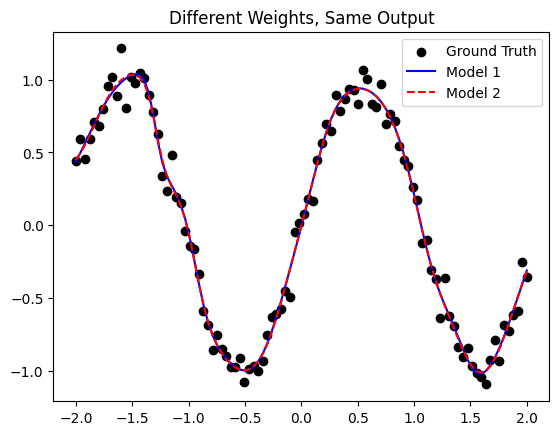

**** Comparing layer 1: ****
Layer weights and biases:
Weights close: False Biases close: False
Number of parameters in layer:
Number of weights (model1): 32 Number of biases (model1): 32
Number of weights (model2): 32 Number of biases (model2): 32
Number of differing biases: 32
Number of differing weights: 32
**** Comparing layer 2: ****
Layer weights and biases:
Weights close: False Biases close: False
Number of parameters in layer:
Number of weights (model1): 1024 Number of biases (model1): 32
Number of weights (model2): 1024 Number of biases (model2): 32
Number of differing biases: 32
Number of differing weights: 1024
**** Comparing layer 3: ****
Layer weights and biases:
Weights close: False Biases close: False
Number of parameters in layer:
Number of weights (model1): 32 Number of biases (model1): 1
Number of weights (model2): 32 Number of biases (model2): 1
Number of differing biases: 1
Number of differing weights: 32


In [ ]:
# === 6. Predict and plot ===
y1 = jax.vmap(model1)(x)
y2 = jax.vmap(model2)(x)

plt.scatter(x, y, label="Ground Truth", color="black")
plt.plot(x, y1, label="Model 1", color="blue")
plt.plot(x, y2, label="Model 2", color="red", linestyle="--")
plt.legend()
plt.title("Different Weights, Same Output")
plt.show()


# === 7. Compare parameters ===
def compare_models(m1, m2):
    for i, l12 in enumerate(zip(m1.layers, m2.layers)):
        l1, l2 = l12
        print(f"**** Comparing layer {i + 1}: ****")

        print("Layer weights and biases:")
        w_close = jnp.allclose(l1.weight, l2.weight, atol=1e-1)
        b_close = jnp.allclose(l1.bias, l2.bias, atol=1e-1)
        print("Weights close:", w_close, "Biases close:", b_close)

        print("Number of parameters in layer:")
        print(
            "Number of weights (model1):",
            l1.weight.size,
            "Number of biases (model1):",
            l1.bias.size,
        )
        print(
            "Number of weights (model2):",
            l2.weight.size,
            "Number of biases (model2):",
            l2.bias.size,
        )
        print("Number of differing biases:", jnp.sum(l1.bias != l2.bias))
        print("Number of differing weights:", jnp.sum(l1.weight != l2.weight))


compare_models(model1, model2)